# SWOT denoising module: description and use

* Emmanuel Cosme, Laura Gómez Navarro, Julien Le Sommer, Nicolas Papadakis, Ananda Pascual, Audrey Monsimer
* Objective: Describe the denoising methods and show how to call them
* Created on March 2018

In [1]:
import time

print('Last update:', time.ctime(time.time())) 


Last update: Fri Oct 20 11:32:43 2023


## 0. Imports, versions, plots, input files

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import xarray as xr
import os

import SWOTdenoise as swotd

# Libraries needed in SWOT module
import netCDF4
import scipy


In [3]:
# Gulf Stream region
region = 'GS'
lon_min = 282                                          # domain min longitude
lon_max = 292                                          # domain max longitude
lat_min = 30.                                          # domain min latitude
lat_max = 40.                                          # domain max latitude 


In [6]:
output_dirname = '../denoised_data/'
method_name = 'gomezfilt'

In [4]:
filepath = '../swot_data/'
filename='SWOT_L3_LR_SSH_Expert_542_009_20230604T181344_20230604T190449_v0.1.nc'

In [5]:
ds_swot = xr.open_mfdataset(filepath+filename)

ds_swot = ds_swot.where(ds_swot['longitude']<lon_max,drop=True)
ds_swot = ds_swot.where(ds_swot['longitude']>lon_min,drop=True)
ds_swot = ds_swot.where(ds_swot['latitude']<lat_max,drop=True)
ds_swot = ds_swot.where(ds_swot['latitude']>lat_min,drop=True)

/Users/sammymetref/miniconda3/envs/env-dc-global-ose0/lib/python3.10/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/Users/sammymetref/miniconda3/envs/env-dc-global-ose0/lib/python3.10/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     

## 1. Call the ```SWOTdenoise``` function
The ```SWOTdenoise``` function can be called by providing the SWOT Netcdf file name only. In this case, the denoised field is returned in another Netcdf file named **foo_denoised.nc** if the input file is **foo.nc**. It is created in the same directory.

gap already filled
shape ssh_f (582, 61)
Method: gaussian
gap already filled
shape ssh_f (582, 61)
Method: var_reg_fista


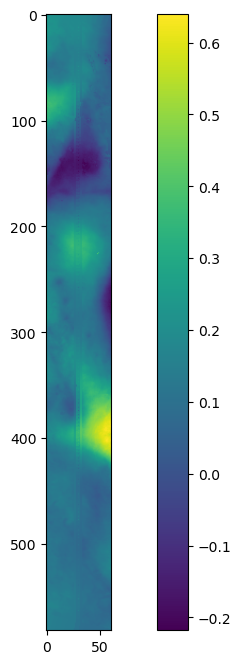

(0, 0, 8)
Iteration reached: 1000
norm/epsilon = 44.01


/var/folders/7z/0lhl8z593jd0wrmnzm1lysdr0000gp/T/ipykernel_65240/2411724006.py:96: SerializationWarning: saving variable latitude with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_swot.to_netcdf(output_dirname+'/'+filename[:-3]+'_gomezfilt.nc')
/var/folders/7z/0lhl8z593jd0wrmnzm1lysdr0000gp/T/ipykernel_65240/2411724006.py:96: SerializationWarning: saving variable longitude with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds_swot.to_netcdf(output_dirname+'/'+filename[:-3]+'_gomezfilt.nc')


In [7]:
filtername = 'var_reg_fista'

filled = True

ds_swot_r = ds_swot.isel(num_pixels = slice(4,65),drop=True)
  
ssh = ds_swot_r['ssha'].values[:] 
ssh = np.ma.masked_invalid(ssh)
lon = ds_swot_r['longitude'].values[:] 
lat = ds_swot_r['latitude'].values[:] 
time = ds_swot_r['time'].values[:] 
x_ac = ds_swot_r.cross_track_distance.values[:,40]#np.arange(ds_swot['num_pixels'].size) 

if filtername == 'var_reg_fista':
    #params0 = np.zeros_like(ds_swot.ssha) 
    #params1_max = 70
    #params1_min = 1
    # param1 between params1_max and params1_min from low to high laltitude (0<lat_norm<1)
    #params1 = params1_max-(params1_max-params1_min)*lat_norm[inumlines:inumlines+time.size]
    # param1 = 10 when sshvar_val > 0.01 (100 cm2)
    #params1[sshvar_val[inumlines:inumlines+time.size]>0.03] = 10 
    #params2 = np.zeros_like(ds_swot.ssha)
    #params = (params0,params1,params2)
    params = (0,0,8)

if filtername == 'boxcar':
    params = 4. 
if filtername == 'gaussian':
    params = 5.


if ~np.all(ssh.mask): 

    if filled: 
        ssh_filt0, _ = swotd.SWOTdenoise(ssh=ssh, lon=lon, lat=lat, x_ac=x_ac, time=ds_swot_r.num_lines, method='gaussian', param=5,itermax=500)
 
        ssh_filled = scipy.interpolate.griddata((lon[~ssh.mask], lat[~ssh.mask]), ssh_filt0[~ssh_filt0.mask].ravel(),
                              (lon, lat),
                                 method='nearest')

    
        ssh_filled[~np.isnan(ssh)] = ssh[~np.isnan(ssh)]
        
        ssh_filled = np.ma.masked_invalid(ssh_filled)
        #mask_ssh = np.zeros_like(ssh_filled) 
        #ssh_filled = np.ma.masked_array(ssh_filled,mask_ssh) 
        
        #from scipy import ndimage as nd
        #ssh_filled = nd.gaussian_filter(ssh_filled, sigma = 1)
    else:  
        ssh[ssh.mask] = 2.14748365e+09
        ssh = np.ma.masked_where(ssh==2.14748365e+09,ssh,copy=False)
        ssh_filled = np.ma.masked_invalid(ssh)
        ssh_filled = np.ma.masked_invalid(ssh_filled) 

        # Increasing the mask by one pixel for unreasonable coastal values
        #for ipix in ds_swot.num_pixels.values:   
        #    old_line = ssh_filled[:,ipix] 
        #    new_line = np.ma.masked_array(old_line,(cumsum_trick_nocopy(old_line,1).mask+cumsum_trick_nocopy(old_line[::-1],1).mask[::-1]))
        #    ssh_filled[:,ipix] = new_line

    ssh_filt, _ = swotd.SWOTdenoise(ssh=ssh_filled, lon=lon, lat=lat, x_ac=x_ac, time=ds_swot_r.num_lines, method=filtername, param=params,itermax=1000)
else:  
    ssh_filt = ssh

ssh_filt = np.ma.masked_array(ssh_filt)#,ssh.mask)

# Masking filtered SWOT under 5km of the coast
#ssh_filt[dist2coast[inumlines:inumlines+time.size]<5] = np.nan

ssh_filt = np.ma.masked_invalid(ssh_filt) 

#ds_swot['ssha_gomezfilt'] = ds_swot['ssha']
ds_swot = ds_swot.assign(ssha_gomezfilt=lambda ds_swot: ds_swot.ssha_noiseless)
ssh_filt_large = np.array(ds_swot['ssha_gomezfilt'].values)
ssh_filt_large[:,6:63] = ssh_filt[:,2:-2]
ssh_filt_large[np.isnan(ds_swot['ssha'].values)] = np.nan
ds_swot['ssha_gomezfilt'].values = ssh_filt_large 

n_p,n_l = np.meshgrid(ds_swot.num_pixels,ds_swot.num_lines)

if False: 
    plt.figure()
    plt.subplot(121)
    plt.pcolormesh(n_p,n_l,ssh-ds_swot.ssh_true,cmap='bwr')
    plt.colorbar()
    print(np.nanmean(np.abs(ssh-ds_swot.ssh_true)))

    plt.subplot(122) 
    plt.pcolormesh(n_p,n_l,ssh_filt-ds_swot.ssh_true,cmap='bwr')
    plt.colorbar()
    print(np.nanmean(np.abs(ssh_filt-ds_swot.ssh_true)))
    plt.show()
 

ds_swot.to_netcdf(output_dirname+'/'+filename[:-3]+'_'+method_name+'.nc')

 


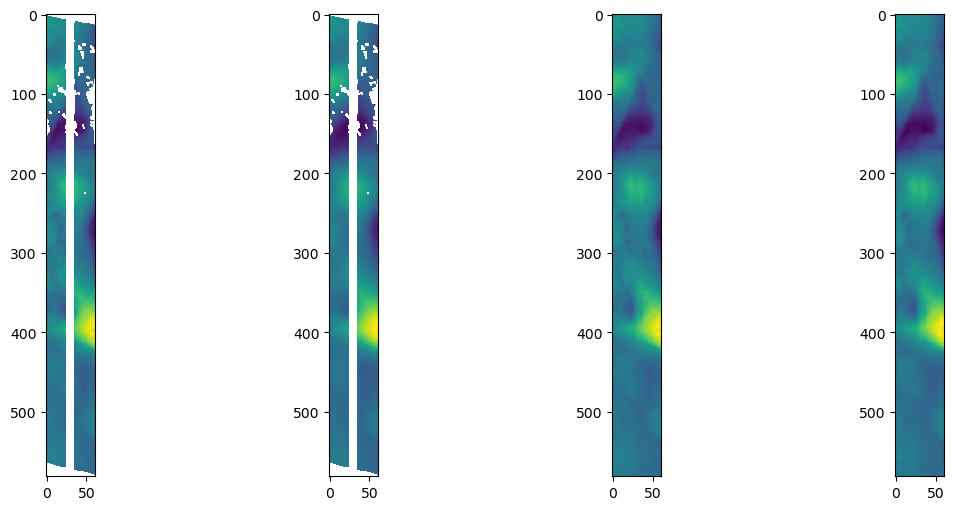

In [8]:
plt.figure(figsize=(14,6))
plt.subplot(141)
plt.imshow(ssh)
plt.subplot(142)
plt.imshow(ssh_filt0)
plt.subplot(143)
plt.imshow(ssh_filled) 
plt.subplot(144)
plt.imshow(ssh_filt) 